In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from PIL import Image
import numpy as np

from segmentation.placement import (
    place_best_tightness,
    propose_grid,
    place_image,
)

ImageType = Image.Image

In [4]:
def get_random_cutout(rng: np.random.Generator | None = None) -> ImageType:
    if rng is None:
        rng = np.random.default_rng()

    images = list(Path("cutouts").glob("*.png"))
    image = Image.open(rng.choice(images))
    # crop to content
    image = image.crop(image.getbbox())
    return image

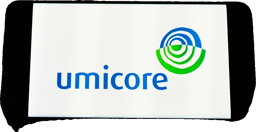

In [5]:
fg = get_random_cutout()
fg

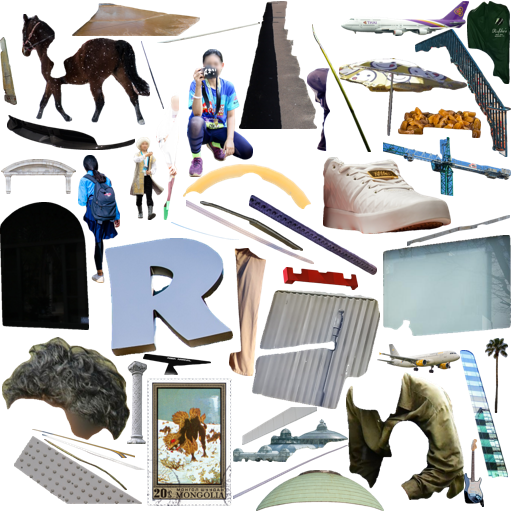

In [15]:
import tqdm.auto
from IPython.display import display, clear_output
from segmentation.placement import propose_random_positions

rng = np.random.default_rng()

img = Image.new("RGBA", (512, 512), color=(0, 0, 0, 0))

n_to_place = 50
n_placed = 0
n_consecutive_failures = 0
scale = 0.5

pbar = tqdm.auto.tqdm(total=n_to_place)

while n_placed < n_to_place:
    cutout = get_random_cutout()
    # display(cutout)
    # scale cutout to 0.5
    cutout = cutout.resize((int(cutout.width * scale), int(cutout.height * scale)))

    # canvas2 = place_greedily(img, propose_random_positions(cutout, img.size, rng=rng))
    canvas2 = place_best_tightness(
        img, propose_random_positions(cutout, img.size, rng=rng)
    )

    if canvas2 is not None:
        img = canvas2
        clear_output(wait=True)
        display(img)
        n_placed += 1
        n_consecutive_failures = 0
        pbar.update(1)
        continue
    else:
        pbar.set_postfix(
            {"scale": scale, "n_consecutive_failures": n_consecutive_failures}
        )
        n_consecutive_failures += 1
        if n_consecutive_failures > 100:
            scale *= 0.9
            print(f"Failed too many times, reducing scale to {scale}")
            n_consecutive_failures = 0

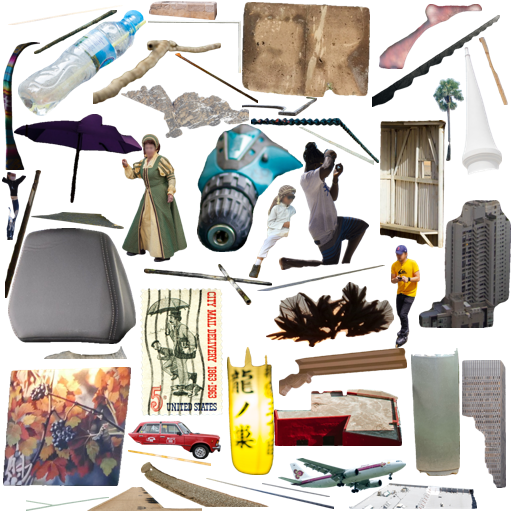

In [21]:
img

In [219]:
from segmentation import placement


cutout = get_random_cutout(rng=np.random.default_rng(22))
cutout = placement.expand_cutout_canvas(cutout, position=(50, 50))
# get_wiggle_room(bg_mask=np.zeros((512,512)), fg_mask=cutout)

In [195]:
import skimage

mask = placement.to_mask(cutout)
# mask = (np.array(cutout) > 0).astype(np.uint8)

mask2 = skimage.morphology.dilation(mask, skimage.morphology.disk(10))

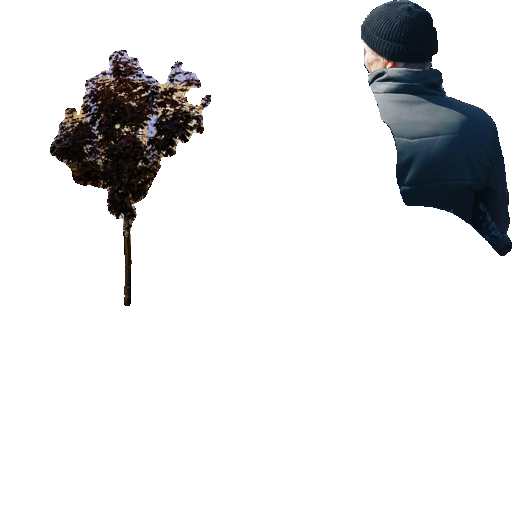

In [11]:
canvas = Image.new("RGBA", (512, 512), color=(255, 255, 255, 0))
cutout = get_random_cutout(rng=np.random.default_rng(21))
canvas = place_image(canvas, cutout, (50, 50))

cutout = get_random_cutout(rng=np.random.default_rng(22))

canvas2 = place_best_tightness(canvas, propose_grid(cutout, canvas.size, grid_size=8))

canvas2.convert("RGB")

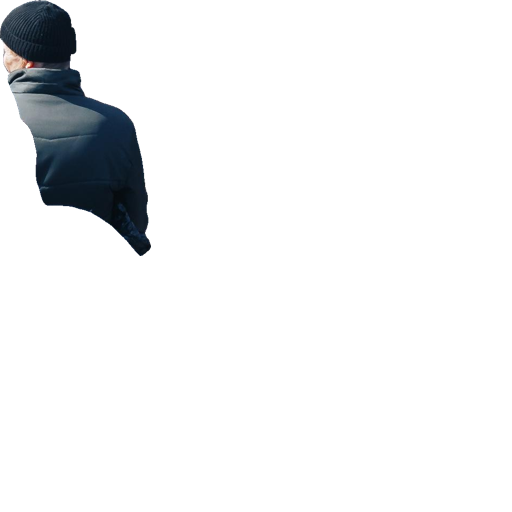

In [213]:
cutout